# Import

In [1]:
import re
import os
import numpy as np
import pandas as pd
import json
import champ_dataset
import random
import tensorflow as tf
from tensorflow.python.client import device_lib
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

2024-09-22 02:52:49.253724: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 02:52:49.272478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 02:52:49.292150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 02:52:49.297999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 02:52:49.312582: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

2.17.0


In [3]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2024-09-22 02:53:12.753168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:0 with 22261 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-22 02:53:12.755389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:1 with 22261 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-09-22 02:53:12.757385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:2 with 22261 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-09-22 02:53:12.758877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:3 with 22261 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-09-22 02:53:12.760159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4657606278343201812
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23342743552
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 4
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 5
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 6
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 7
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 5224806676171494049
 physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capabil

In [4]:
MODEL_NAME = 'distiled_bert'
RUN = 'run3'

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/Data/MATH/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN + '/'
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/Duong_LLM/Data/MATH/
/nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run3/


In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data Champdataset

In [6]:
# =================================Load the dataset==================================
# dataset is a champ_dataset.Dataset instance; 'v0' is the dataset used in the paper
dataset = champ_dataset.load('v0')

# =====================Get a random problem and read its content=====================
# get a random problem; dataset.problems is a dictionary
problem_id = random.choice(list(dataset.problems.keys()))
# shortcut for dataset.problems[problem_id]
problem = dataset[problem_id]
# problem identifier (which is equal to problem_id) and problem statement
print(f'{problem.identifier}: {problem.text}')

P_Combinatorics_14: A gardener plants 3 apple trees, 3 peach trees and 2 cherry trees in a row, with a random order. What is the probability that no two apple trees are next two each other?


In [7]:
champ_topic_mapping = {
    'Polynomial': 0,
    'Sequence': 1,
    'Number-Theory': 2,
    'Combinatorics': 3,
    'Inequality': 4,
}

list_champ_topic_type = ['Polynomial','Sequence','Number-Theory','Combinatorics','Inequality']

In [8]:
problem_type_list = []
problem_text_list = []

for i in dataset.problems.keys():
    problem = dataset[i]
    current_promt = problem.text
    problem_text_list.append(current_promt)
    for current_type in list_champ_topic_type:
        if current_type in problem.identifier:
            problem_type_list.append(current_type)
            break


print(len(problem_type_list), '  ', len(problem_text_list))

270    270


In [9]:
pd.set_option('display.max_colwidth', None)
df= pd.DataFrame()
df['topic'] = problem_type_list
df['problem'] = problem_text_list
df['topic_encoded'] = df['topic'].map(champ_topic_mapping)
df

,topic,problem,topic_encoded
0,Combinatorics,"Let a string consist of digit 1, 2, 3. How many such strings of length 6 have adjacent digit differing by less than or equal to 1?",3
1,Combinatorics,"How many strings of length 5 using the digits {0, 1, ..., 9} (with leading zeros allowed) have strictly increasing digits?",3
2,Combinatorics,"On a chess board, two rooks are placed peacefully if they are not on the same row or column. For an n x n chess board, find the number of ways that n rooks can be placed peacefully (i.e., any two are placed peacefully) and the placing is also invariant to a 180-degree rotation.",3
3,Combinatorics,"A one-to-one mapping p: {1, 2, ..., n}->{1, 2, ..., n} is called an involution, if p∘p=identity (i.e., p(p(i))=i for all i∈{1, ..., n}). Find the number of involutions on {1, 2, 3, 4, 5, 6}.",3
4,Combinatorics,"How many subsets of {1, 2,..., 10} have no two successive numbers?",3
...,...,...,...
265,Sequence,"In how many ways can 12 geometric progressions be selected from the numbers 1, 2, ..., 100 such that every number is in exactly one progression?",1
266,Sequence,"Let x_1=2, y_1=4, z_1=6/7, and define x_(n+1)=2x_n/(x_n^2-1), y_(n+1)=2y_n/(y_n^2-1), z_(n+1)=2z_n/(z_n^2-1). Is it possible for x_n+y_n+z_n=0 for some n?",1
267,Sequence,"A function f(x) satisfies f(x+1)+f(x-1)=sqrt(2)*f(x). Determine whether the function is periodic, and if so, find its period.",1
268,Sequence,"The sequence {x_n} is defined by x_1=2, x_(n+1)=(2+x_n)/(1−2x_n), and it is known that there are no x_n=0. Could x_p=x_q for any p≠q, and if so, find the smallest possible value of p+q.",1


In [10]:
df.groupby(['topic','topic_encoded']).size()

topic          topic_encoded
Combinatorics  3                40
Inequality     4                50
Number-Theory  2                80
Polynomial     0                50
Sequence       1                50
dtype: int64

# Load model

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")
model_loaded = TFDistilBertForSequenceClassification.from_pretrained(OUTPUT_DIR + 'model')
model_loaded.summary()


/home/qdang1/.conda/envs/tf2/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2024-09-22 02:53:14.069823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22261 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-22 02:53:14.070282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22261 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-09-22 02:53:14.070707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:202

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66958855 (255.43 MB)
Trainable params: 66958855 (255.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model_loaded.config

DistilBertConfig {
  "_name_or_path": "/nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run3/model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.5,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.44.2",
  "vocab_size": 30522
}

# Predciting

In [13]:
#function remove all formating character from text
def remove_formatting(text):
    # Remove LaTeX commands
    text = re.sub(r'\\[a-zA-Z]+', '', text)
    # Remove curly braces
    text = re.sub(r'{|}', '', text)
    # Remove Markdown formatting (e.g., **bold**, *italic*, `code`)
    text = re.sub(r'\*\*|\*|`', '', text)
    # Remove Markdown headers (e.g., # Header)
    text = re.sub(r'#', '', text)
    # Remove escape characters
    text = re.sub(r'\\', '', text)
    # remove special character
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\$', '', text)
    # Remove everything after '(A)'
    text = re.sub(r'\(A\).*', '', text)
    text = re.sub(r'\(a\).*', '', text)
    # Remove everything after "b'"
    text = re.sub(r'b\'', '', text)
    return text

In [14]:
def tokenizing_data(data, tokenizer):
    '''
    description:
        The function will take list of data and tokenize it.
    required:
        remove_formatting() function
    input:
        data: list of text.
        tokenizer: tokenizer from DistilBertTokenizer
    output:
        data_encoded: tokenized_data in tf.tensor
    '''
    data_cleared = pd.Series(data).apply(remove_formatting)
    data_encoded = tokenizer(list(data_cleared), truncation=True, padding=True,return_tensors="tf")

    return data_encoded    

In [15]:
def model_predict(data, model):
    '''
    description:
        function will take tokenized data and predict it
    input:
        data: tokenized_data using DistilBertTokenizer, and in tf.tensor type.
        model: model from TFDistilBertForSequenceClassification
    output:
        output: output of model
    '''
    output = model(data)[0]
    return output
    

In [16]:
data_tokenized = tokenizing_data(df['problem'],tokenizer)   #tokenizing
output = model_predict(data_tokenized,model_loaded)         #predicting
output

<tf.Tensor: shape=(270, 7), dtype=float32, numpy=
array([[-0.05403115, -2.8685765 ,  1.1744798 , ..., -3.6686368 ,
         4.7983713 , -2.9514468 ],
       [ 0.12099691, -3.0001395 ,  0.0933995 , ..., -3.5040624 ,
         5.6496506 , -3.5200415 ],
       [ 0.31705886, -2.4629397 , -0.8838614 , ..., -3.421876  ,
         5.922308  , -3.9363537 ],
       ...,
       [ 2.5424788 ,  5.7139144 , -2.023651  , ..., -4.4395247 ,
        -3.0244026 , -3.0138338 ],
       [ 4.546349  ,  3.1787994 , -1.5911268 , ..., -3.9005666 ,
        -2.054008  , -3.5158944 ],
       [ 2.7061212 , -0.4398747 ,  2.0568209 , ..., -3.3263702 ,
        -0.02679787, -2.6014984 ]], dtype=float32)>

In [17]:
y_pred = np.argmax(output,axis=1)
y_test = list(df['topic_encoded'])

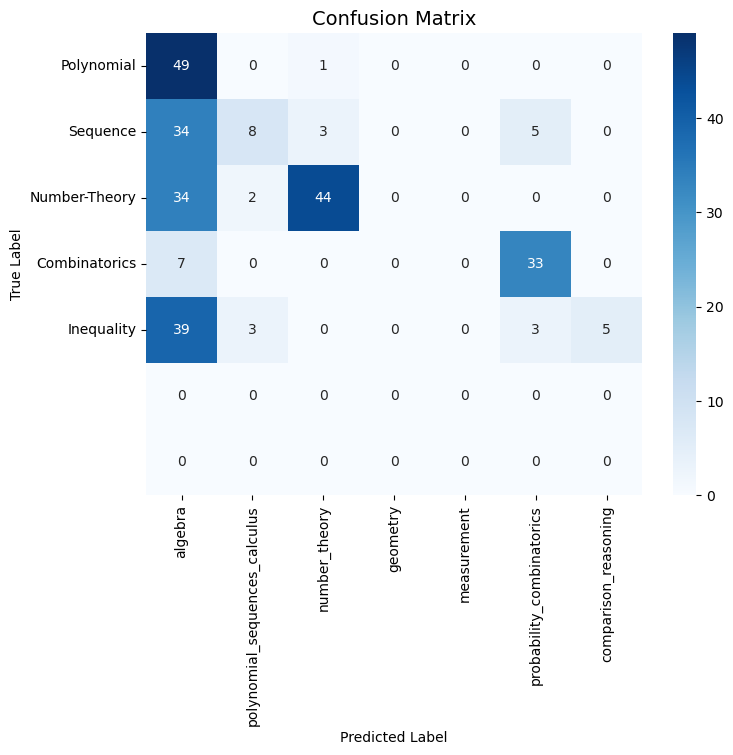

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy, F1 score, and MCC
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
# mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=list_champ_topic_type)

# Add accuracy, F1 score, and MCC in the title
plt.title(f'Confusion Matrix', fontsize=14)

# Label axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_champ.png")
plt.show()